# Lagged Features for Time Series Forecasting

This code demonstrates how pandas-engineered lagged features can be used for time series forecasting with HistGradientBoostingRegressor on the Bike Sharing Demand dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml


In [2]:
bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas"
)
df = bike_sharing.frame
df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0,1


Next, we take a look at the statistical summary of the dataset so that we can better understand the data that we are working with.

In [3]:
summary = pd.DataFrame(df.describe())
summary = (
    summary.style.background_gradient()
    .set_table_attributes("style = 'display: inline'")
    .set_caption("Statistics of the Dataset")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "16px")]}])
)
summary

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,11.546752,3.003683,20.376474,23.788755,0.627229,12.736540,189.463088
std,0.500008,3.438776,6.914405,2.005771,7.894801,8.592511,0.192930,8.196795,181.387599
min,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,1.000000,13.940000,16.665000,0.480000,7.001500,40.000000
50%,1.000000,7.000000,12.000000,3.000000,20.500000,24.240000,0.630000,12.998000,142.000000
75%,1.000000,10.000000,18.000000,5.000000,27.060000,31.060000,0.780000,16.997900,281.000000
max,1.000000,12.000000,23.000000,6.000000,41.000000,50.000000,1.000000,56.996900,977.000000


In [4]:
import matplotlib.pyplot as plt

df["season"].value_counts()

season
fall      4496
summer    4409
spring    4242
winter    4232
Name: count, dtype: int64

#### Generating pandas-engineered lagged features

Let’s consider the problem of predicting the demand at the next hour given past demands. Since the demand is a continuous variable, one could intuitively use any regression model. However, we do not have the usual (X_train, y_train) dataset. Instead, we just have the y_train demand data sequentially organized by time.

In [5]:
count = df["count"]
lagged_df = pd.concat(
    [
        count,
        count.shift(1).rename("lagged_count_1h"),
        count.shift(2).rename("lagged_count_2h"),
        count.shift(3).rename("lagged_count_3h"),
        count.shift(24).rename("lagged_count_1d"),
        count.shift(24 + 1).rename("lagged_count_1d_1h"),
        count.shift(7 * 24).rename("lagged_count_7d"),
        count.shift(7 * 24 + 1).rename("lagged_count_7d_1h"),
        count.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        count.shift(1).rolling(24).max().rename("lagged_max_24h"),
        count.shift(1).rolling(24).min().rename("lagged_min_24h"),
        count.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        count.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        count.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
)
lagged_df.tail(10)

,count,lagged_count_1h,lagged_count_2h,lagged_count_3h,lagged_count_1d,lagged_count_1d_1h,lagged_count_7d,lagged_count_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
17369,247,203.0,224.0,157.0,160.0,169.0,70.0,135.0,93.500000,224.0,1.0,67.732143,271.0,1.0
17370,315,247.0,203.0,224.0,138.0,160.0,46.0,70.0,97.125000,247.0,1.0,68.785714,271.0,1.0
17371,214,315.0,247.0,203.0,133.0,138.0,33.0,46.0,104.500000,315.0,1.0,70.386905,315.0,1.0
17372,164,214.0,315.0,247.0,123.0,133.0,33.0,33.0,107.875000,315.0,1.0,71.464286,315.0,1.0
17373,122,164.0,214.0,315.0,125.0,123.0,26.0,33.0,109.583333,315.0,1.0,72.244048,315.0,1.0
17374,119,122.0,164.0,214.0,102.0,125.0,26.0,26.0,109.458333,315.0,1.0,72.815476,315.0,1.0
17375,89,119.0,122.0,164.0,72.0,102.0,18.0,26.0,110.166667,315.0,1.0,73.369048,315.0,1.0
17376,90,89.0,119.0,122.0,47.0,72.0,23.0,18.0,110.875000,315.0,1.0,73.791667,315.0,1.0
17377,61,90.0,89.0,119.0,36.0,47.0,22.0,23.0,112.666667,315.0,1.0,74.190476,315.0,1.0
17378,49,61.0,90.0,89.0,49.0,36.0,12.0,22.0,113.708333,315.0,1.0,74.422619,315.0,1.0


In [6]:
lagged_df.head(10)

,count,lagged_count_1h,lagged_count_2h,lagged_count_3h,lagged_count_1d,lagged_count_1d_1h,lagged_count_7d,lagged_count_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
0,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32,40.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,32.0,40.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,13.0,32.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,1.0,13.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2,1.0,1.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,14,8.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can now separate the lagged features in a matrix X and the target variable (the counts to predict) in an array of the same first dimension y.

In [7]:
lagged_df = lagged_df.dropna()
X = lagged_df.drop("count", axis="columns")
y = lagged_df["count"]
print("X shape: {}\ny shape: {}".format(X.shape, y.shape))

X shape: (17210, 13)
y shape: (17210,)


#### Naive evaluation of the next hour bike demand regression

Let’s randomly split our tabularized dataset to train a gradient boosting regression tree (GBRT) model and evaluate it using Mean Absolute Percentage Error (MAPE). If our model is aimed at forecasting (i.e., predicting future data from past data), we should not use training data that are ulterior to the testing data. In time series machine learning the “i.i.d” (independent and identically distributed) assumption does not hold true as the data points are not independent and have a temporal relationship

In [8]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = HistGradientBoostingRegressor().fit(X_train, y_train)

In [9]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.39318620336227555

#### Proper next hour forecasting evaluation

Let’s use a proper evaluation splitting strategies that takes into account the temporal structure of the dataset to evaluate our model’s ability to predict data points in the future (to avoid cheating by reading values from the lagged features in the training set).

In [10]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=3,  # to keep the notebook fast enough on common laptops
    gap=48,  # 2 days data gap between train and test
    max_train_size=10000,  # keep train sets of comparable sizes
    test_size=3000,  # for 2 or 3 digits of precision in scores
)
all_splits = list(ts_cv.split(X, y))

In [11]:
train_idx, test_idx = all_splits[0]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

model = HistGradientBoostingRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.44300751539296973

The generalization error measured via a shuffled trained test split is too optimistic. The generalization via a time-based split is likely to be more representative of the true performance of the regression model. Let’s assess this variability of our error evaluation with proper cross-validation

In [12]:
from sklearn.model_selection import cross_val_score

cv_mape_scores = -cross_val_score(
    model, X, y, cv=ts_cv, scoring="neg_mean_absolute_percentage_error"
)
cv_mape_scores

array([0.44300752, 0.27772182, 0.3697178 ])

The variability across splits is quite large! In a real life setting it would be advised to use more splits to better assess the variability. Let’s report the mean CV scores and their standard deviation from now on.

In [13]:
print(f"CV MAPE: {cv_mape_scores.mean():.3f} ± {cv_mape_scores.std():.3f}")

CV MAPE: 0.363 ± 0.068


We can compute several combinations of evaluation metrics and loss functions, which are reported a bit below.

In [14]:
from collections import defaultdict

from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_pinball_loss,
    root_mean_squared_error,
)
from sklearn.model_selection import cross_validate


def consolidate_scores(cv_results, scores, metric):
    if metric == "MAPE":
        scores[metric].append(f"{value.mean():.2f} ± {value.std():.2f}")
    else:
        scores[metric].append(f"{value.mean():.1f} ± {value.std():.1f}")

    return scores


scoring = {
    "MAPE": make_scorer(mean_absolute_percentage_error),
    "RMSE": make_scorer(root_mean_squared_error),
    "MAE": make_scorer(mean_absolute_error),
    "pinball_loss_05": make_scorer(mean_pinball_loss, alpha=0.05),
    "pinball_loss_50": make_scorer(mean_pinball_loss, alpha=0.50),
    "pinball_loss_95": make_scorer(mean_pinball_loss, alpha=0.95),
}
loss_functions = ["squared_error", "poisson", "absolute_error"]
scores = defaultdict(list)
for loss_func in loss_functions:
    model = HistGradientBoostingRegressor(loss=loss_func)
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=ts_cv,
        scoring=scoring,
        n_jobs=2,
    )
    time = cv_results["fit_time"]
    scores["loss"].append(loss_func)
    scores["fit_time"].append(f"{time.mean():.2f} ± {time.std():.2f} s")

    for key, value in cv_results.items():
        if key.startswith("test_"):
            metric = key.split("test_")[1]
            scores = consolidate_scores(cv_results, scores, metric)

#### Modeling predictive uncertainty via quantile regression

Instead of modeling the expected value of the distribution of Y|X like the least squares and Poisson losses do, one could try to estimate quantiles of the conditional distribution.

Y|X = xi is expected to be a random variable for a given data point xi because we expect that the number of rentals cannot be 100% accurately predicted from the features. It can be influenced by other variables not properly captured by the existing lagged features. For instance whether or not it will rain in the next hour cannot be fully anticipated from the past hours bike rental data. This is what we call aleatoric uncertainty.

Quantile regression makes it possible to give a finer description of that distribution without making strong assumptions on its shape.

In [15]:
quantile_list = [0.05, 0.5, 0.95]

for quantile in quantile_list:
    model = HistGradientBoostingRegressor(loss="quantile", quantile=quantile)
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=ts_cv,
        scoring=scoring,
        n_jobs=2,
    )
    time = cv_results["fit_time"]
    scores["fit_time"].append(f"{time.mean():.2f} ± {time.std():.2f} s")

    scores["loss"].append(f"quantile {int(quantile*100)}")
    for key, value in cv_results.items():
        if key.startswith("test_"):
            metric = key.split("test_")[1]
            scores = consolidate_scores(cv_results, scores, metric)

df = pd.DataFrame(scores)

styled_df_copy = df.copy()


def extract_numeric(value):
    parts = value.split("±")
    mean_value = float(parts[0])
    std_value = float(parts[1].split()[0])

    return mean_value, std_value


# Convert columns containing "±" to tuples of numerical values
cols_to_convert = df.columns[1:]  # Exclude the "loss" column
for col in cols_to_convert:
    df[col] = df[col].apply(extract_numeric)

min_values = df.min()

# Create a mask for highlighting minimum values
mask = pd.DataFrame("", index=df.index, columns=df.columns)
for col in cols_to_convert:
    mask[col] = df[col].apply(
        lambda x: "font-weight: bold" if x == min_values[col] else ""
    )

styled_df_copy = styled_df_copy.style.apply(lambda x: mask, axis=None)
styled_df_copy

,loss,fit_time,MAPE,RMSE,MAE,pinball_loss_05,pinball_loss_50,pinball_loss_95
0,squared_error,0.78 ± 0.18 s,0.36 ± 0.07,62.3 ± 3.5,39.1 ± 2.3,17.7 ± 1.3,19.5 ± 1.1,21.4 ± 2.4
1,poisson,0.80 ± 0.23 s,0.32 ± 0.07,64.2 ± 4.0,39.3 ± 2.8,16.7 ± 1.5,19.7 ± 1.4,22.6 ± 3.0
2,absolute_error,0.90 ± 0.20 s,0.32 ± 0.06,64.6 ± 3.8,39.9 ± 3.2,17.1 ± 1.1,19.9 ± 1.6,22.7 ± 3.1
3,quantile 5,0.93 ± 0.23 s,0.41 ± 0.01,145.6 ± 20.9,92.5 ± 16.2,5.9 ± 0.9,46.2 ± 8.1,86.6 ± 15.3
4,quantile 50,1.00 ± 0.25 s,0.32 ± 0.06,64.6 ± 3.8,39.9 ± 3.2,17.1 ± 1.1,19.9 ± 1.6,22.7 ± 3.1
5,quantile 95,0.95 ± 0.25 s,1.07 ± 0.27,99.6 ± 8.7,72.0 ± 6.1,62.9 ± 7.4,36.0 ± 3.1,9.1 ± 1.3


Even if the score distributions overlap due to the variance in the dataset, it is true that the average RMSE is lower when loss="squared_error", whereas the average MAPE is lower when loss="absolute_error" as expected. That is also the case for the Mean Pinball Loss with the quantiles 5 and 95. The score corresponding to the 50 quantile loss is overlapping with the score obtained by minimizing other loss functions, which is also the case for the MAE.

#### A qualitative look at the predictions

We can now visualize the performance of the model with regards to the 5th percentile, median and the 95th percentile:

In [16]:
all_splits = list(ts_cv.split(X, y))
train_idx, test_idx = all_splits[0]

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

max_iter = 50
gbrt_mean_poisson = HistGradientBoostingRegressor(loss="poisson", max_iter=max_iter)
gbrt_mean_poisson.fit(X_train, y_train)
mean_predictions = gbrt_mean_poisson.predict(X_test)

gbrt_median = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.5, max_iter=max_iter
)
gbrt_median.fit(X_train, y_train)
median_predictions = gbrt_median.predict(X_test)

gbrt_percentile_5 = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.05, max_iter=max_iter
)
gbrt_percentile_5.fit(X_train, y_train)
percentile_5_predictions = gbrt_percentile_5.predict(X_test)

gbrt_percentile_95 = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.95, max_iter=max_iter
)
gbrt_percentile_95.fit(X_train, y_train)
percentile_95_predictions = gbrt_percentile_95.predict(X_test)

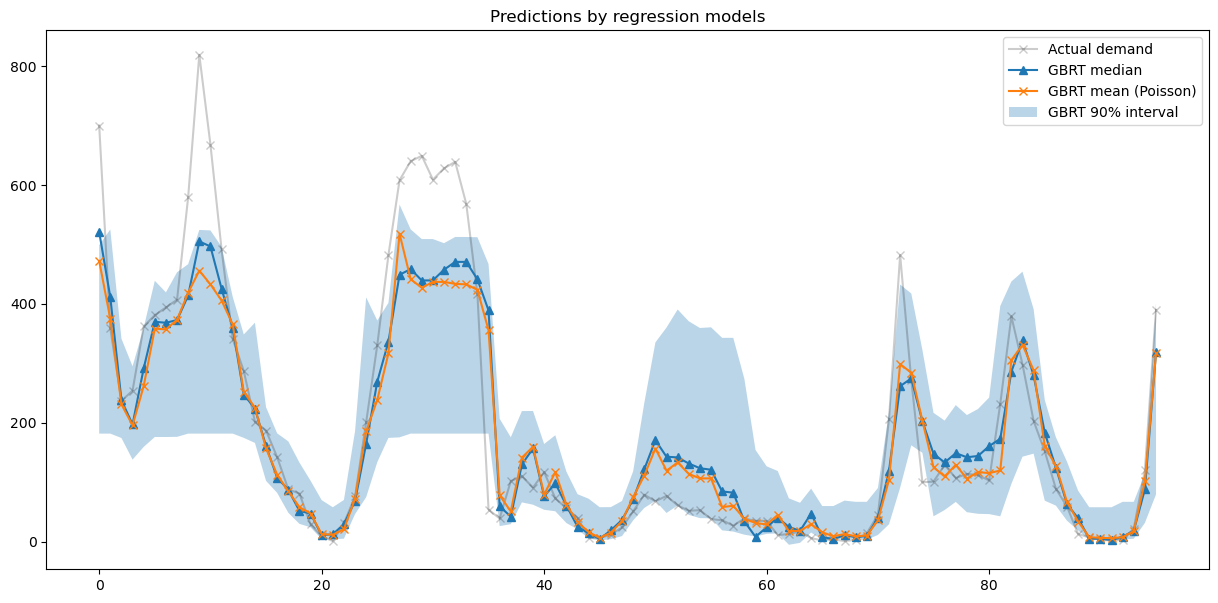

In [17]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(15, 7))
plt.title("Predictions by regression models")
ax.plot(
    y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    median_predictions[last_hours],
    "^-",
    label="GBRT median",
)
ax.plot(
    mean_predictions[last_hours],
    "x-",
    label="GBRT mean (Poisson)",
)
ax.fill_between(
    np.arange(96),
    percentile_5_predictions[last_hours],
    percentile_95_predictions[last_hours],
    alpha=0.3,
    label="GBRT 90% interval",
)
_ = ax.legend()

Here it’s interesting to notice that the blue area between the 5% and 95% percentile estimators has a width that varies with the time of the day:

- At night, the blue band is much narrower: the pair of models is quite certain that there will be a small number of bike rentals. And furthermore these seem correct in the sense that the actual demand stays in that blue band.
- During the day, the blue band is much wider: the uncertainty grows, probably because of the variability of the weather that can have a very large impact, especially on week-ends.
- We can also see that during week-days, the commute pattern is still visible in the 5% and 95% estimations.
- Finally, it is expected that 10% of the time, the actual demand does not lie between the 5% and 95% percentile estimates. On this test span, the actual demand seems to be higher, especially during the rush hours. It might reveal that our 95% percentile estimator underestimates the demand peaks. This could be be quantitatively confirmed by computing empirical coverage numbers as done in the calibration of confidence intervals.

Looking at the performance of non-linear regression models vs the best models:

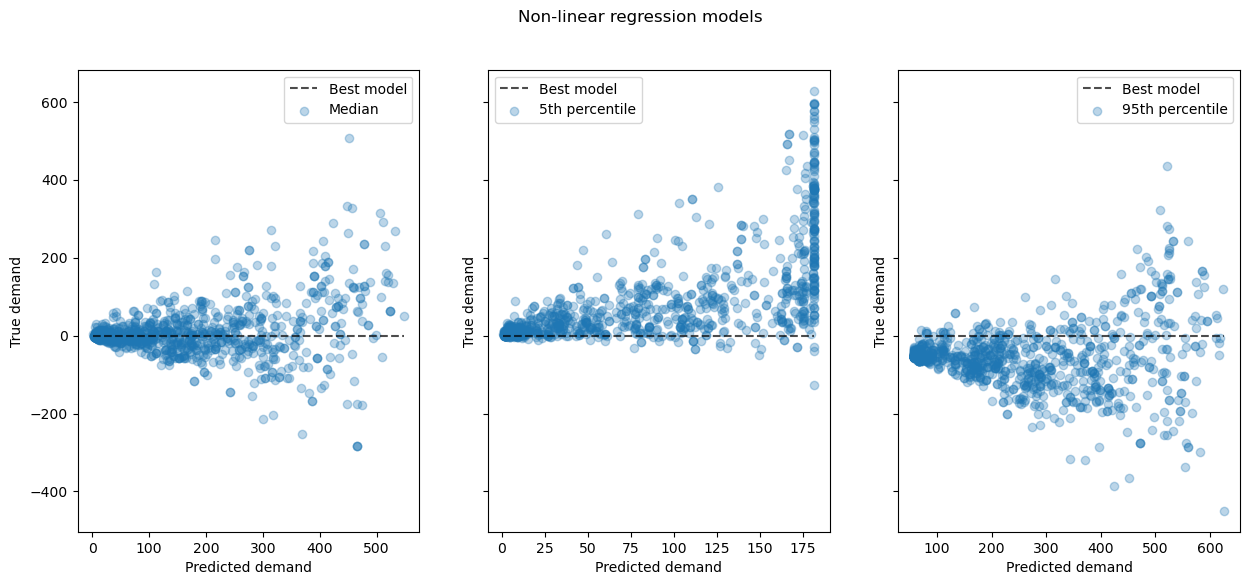

In [18]:
from sklearn.metrics import PredictionErrorDisplay

fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    median_predictions,
    percentile_5_predictions,
    percentile_95_predictions,
]
labels = [
    "Median",
    "5th percentile",
    "95th percentile",
]
for ax, pred, label in zip(axes, predictions, labels):
    PredictionErrorDisplay.from_predictions(
        y_true=y_test.values,
        y_pred=pred,
        kind="residual_vs_predicted",
        scatter_kwargs={"alpha": 0.3},
        ax=ax,
    )
    ax.set(xlabel="Predicted demand", ylabel="True demand")
    ax.legend(["Best model", label])

plt.show()

#### Conclusion

We explored time series forecasting using lagged features. We compared a naive regression (using the standardized train_test_split) with a proper time series evaluation strategy using TimeSeriesSplit. We observed that the model trained using train_test_split, having a default value of shuffle set to True produced an overly optimistic Mean Average Percentage Error (MAPE). The results produced from the time-based split better represent the performance of our time-series regression model. 

We also analyzed the predictive uncertainty of our model via Quantile Regression. Predictions based on the 5th and 95th percentile using loss="quantile" provide us with a quantitative estimate of the uncertainty of the forecasts made by our time series regression model. Uncertainty estimation can also be performed using MAPIE, that provides an implementation based on recent work on conformal prediction methods and estimates both aleatoric and epistemic uncertainty at the same time. 